# **0.1 Importing All Necessary Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from math import sqrt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor, plot_importance
import shap
from sklearn.metrics import make_scorer, r2_score

# **0.2 Importing the Data**

In [ ]:
#Importing the data

data_url = "https://raw.githubusercontent.com/omkary14/CHE1147-Project/refs/heads/main/blast_damage.csv"
df = pd.read_csv(data_url)
df = df.dropna()
df.drop_duplicates(inplace=True)
df = df[df['BLEVE Height (m)'] > 0]
columns_to_drop = ['ID', 'Sensor ID']
df = df.drop(columns=columns_to_drop, axis=1)
df.head()

,Tank Failure Pressure (bar),Liquid Ratio (%),Tank Width (m),Tank Length (m),Tank Height (m),BLEVE Height (m),Vapour Height (m),Vapour Temperature (K),Liquid Temperature (K),Obstacle Distance to BLEVE (m),...,Obstacle Angle,Status,Liquid Critical Pressure (bar),Liquid Boiling Temperature (K),Liquid Critical Temperature (K),Sensor Position Side,Sensor Position x,Sensor Position y,Sensor Position z,Target Pressure (bar)
0,7.32,0.42,2.42,5.39,1.00,1.79,0.60,524.61,354.49,11.0,...,13.0,Superheated,37.9,-1.0,152.0,2.0,12.15,7.90,10.7,0.199929
1,7.18,0.42,2.39,5.39,1.01,1.81,0.59,522.80,354.31,11.0,...,13.0,Superheated,37.9,-1.0,152.0,3.0,12.50,-2.95,-1.9,0.435681
2,7.32,0.41,2.39,5.38,1.00,1.78,0.62,523.00,354.59,11.0,...,13.0,Superheated,37.9,-1.0,152.0,3.0,12.50,-2.95,4.4,0.264031
3,7.26,0.42,2.40,5.41,1.00,1.81,0.61,522.35,354.37,11.0,...,13.0,Superheated,37.9,-1.0,152.0,3.0,12.50,-2.95,10.7,0.270576
4,7.32,0.42,2.40,5.41,1.02,1.79,0.62,522.98,354.33,11.0,...,13.0,Superheated,37.9,-1.0,152.0,4.0,12.50,-2.70,11.0,0.204675


# **0.3 Cleaning the Data**

- This part of the code must be **run only once**.
- We have used the IQR method here. This results in the removal of datapoints since the 'lower_bound' and 'upper_bound' depend on the new quartiles formed each time the code is run.

In [ ]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()


def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

initial_shape = df.shape[0]

for col in numerical_cols:
    df = remove_outliers_iqr(df, col)
    print(f"Removed outliers in column '{col}'. New shape: {df.shape}")

df['Status'] = df['Status'].str.replace('.*ol.*', 'Supercooled', regex=True, case=False)
df['Status'] = df['Status'].str.replace('.*he.*', 'Superheated', regex=True, case=False)

Removed outliers in column 'Tank Failure Pressure (bar)'. New shape: (9532, 23)
Removed outliers in column 'Liquid Ratio (%)'. New shape: (9532, 23)
Removed outliers in column 'Tank Width (m)'. New shape: (9532, 23)
Removed outliers in column 'Tank Length (m)'. New shape: (9532, 23)
Removed outliers in column 'Tank Height (m)'. New shape: (9532, 23)
Removed outliers in column 'BLEVE Height (m)'. New shape: (9532, 23)
Removed outliers in column 'Vapour Height (m)'. New shape: (9480, 23)
Removed outliers in column 'Vapour Temperature (K)'. New shape: (9480, 23)
Removed outliers in column 'Liquid Temperature (K)'. New shape: (9480, 23)
Removed outliers in column 'Obstacle Distance to BLEVE (m)'. New shape: (9480, 23)
Removed outliers in column 'Obstacle Width (m)'. New shape: (9480, 23)
Removed outliers in column 'Obstacle Height (m)'. New shape: (9480, 23)
Removed outliers in column 'Obstacle Thickness (m)'. New shape: (9480, 23)
Removed outliers in column 'Obstacle Angle'. New shape: (9

In [ ]:
df.describe()

,Tank Failure Pressure (bar),Liquid Ratio (%),Tank Width (m),Tank Length (m),Tank Height (m),BLEVE Height (m),Vapour Height (m),Vapour Temperature (K),Liquid Temperature (K),Obstacle Distance to BLEVE (m),...,Obstacle Thickness (m),Obstacle Angle,Liquid Critical Pressure (bar),Liquid Boiling Temperature (K),Liquid Critical Temperature (K),Sensor Position Side,Sensor Position x,Sensor Position y,Sensor Position z,Target Pressure (bar)
count,8551.000000,8551.000000,8551.000000,8551.000000,8551.000000,8551.000000,8551.000000,8551.000000,8551.000000,8551.000000,...,8551.000000,8551.000000,8551.000000,8551.000000,8551.000000,8551.000000,8551.000000,8551.000000,8551.000000,8551.000000
mean,22.897163,0.517078,1.689073,5.479376,1.631503,1.067138,0.793541,397.062853,342.365795,11.482400,...,1.675243,14.836861,40.064168,-20.289323,125.982938,2.353058,13.222539,3.193434,3.178576,0.241276
std,10.512295,0.230429,0.766727,2.602883,0.742921,0.553074,0.503973,71.342309,35.240968,4.039413,...,0.747071,9.301986,2.296120,20.465416,27.603353,1.390491,4.116873,4.771637,4.136884,0.189326
min,4.920000,0.100000,0.380000,0.580000,0.380000,0.010000,0.180000,281.210000,282.950000,5.000000,...,0.380000,0.000000,37.900000,-42.000000,96.700000,1.000000,5.150000,-9.050000,-2.800000,0.016098
25%,13.585000,0.310000,1.010000,3.210000,1.000000,0.600000,0.400000,337.335000,312.160000,8.000000,...,1.010000,6.000000,37.900000,-42.000000,96.700000,1.000000,9.700000,0.000000,-0.600000,0.095322
50%,22.420000,0.520000,1.610000,5.400000,1.590000,1.180000,0.610000,387.690000,341.810000,11.000000,...,1.610000,15.000000,37.900000,-1.000000,152.000000,2.000000,13.150000,3.000000,2.500000,0.179148
75%,31.970000,0.720000,2.390000,7.800000,2.220000,1.590000,1.020000,443.485000,365.090000,15.000000,...,2.390000,23.000000,42.500000,-1.000000,152.000000,3.000000,16.550000,6.700000,5.400000,0.340125
max,42.090000,0.900000,3.020000,10.020000,3.020000,2.020000,2.400000,573.300000,424.360000,20.000000,...,3.020000,30.000000,42.500000,-1.000000,152.000000,5.000000,23.750000,15.750000,14.000000,0.866276


In [ ]:
numeric_df = df.select_dtypes(include=['number'])
num_col_lst = numeric_df.columns.tolist()


# ***1. Exploratory Data Analysis (EDA):***

### **1.1 Distributions of the features and target variables**

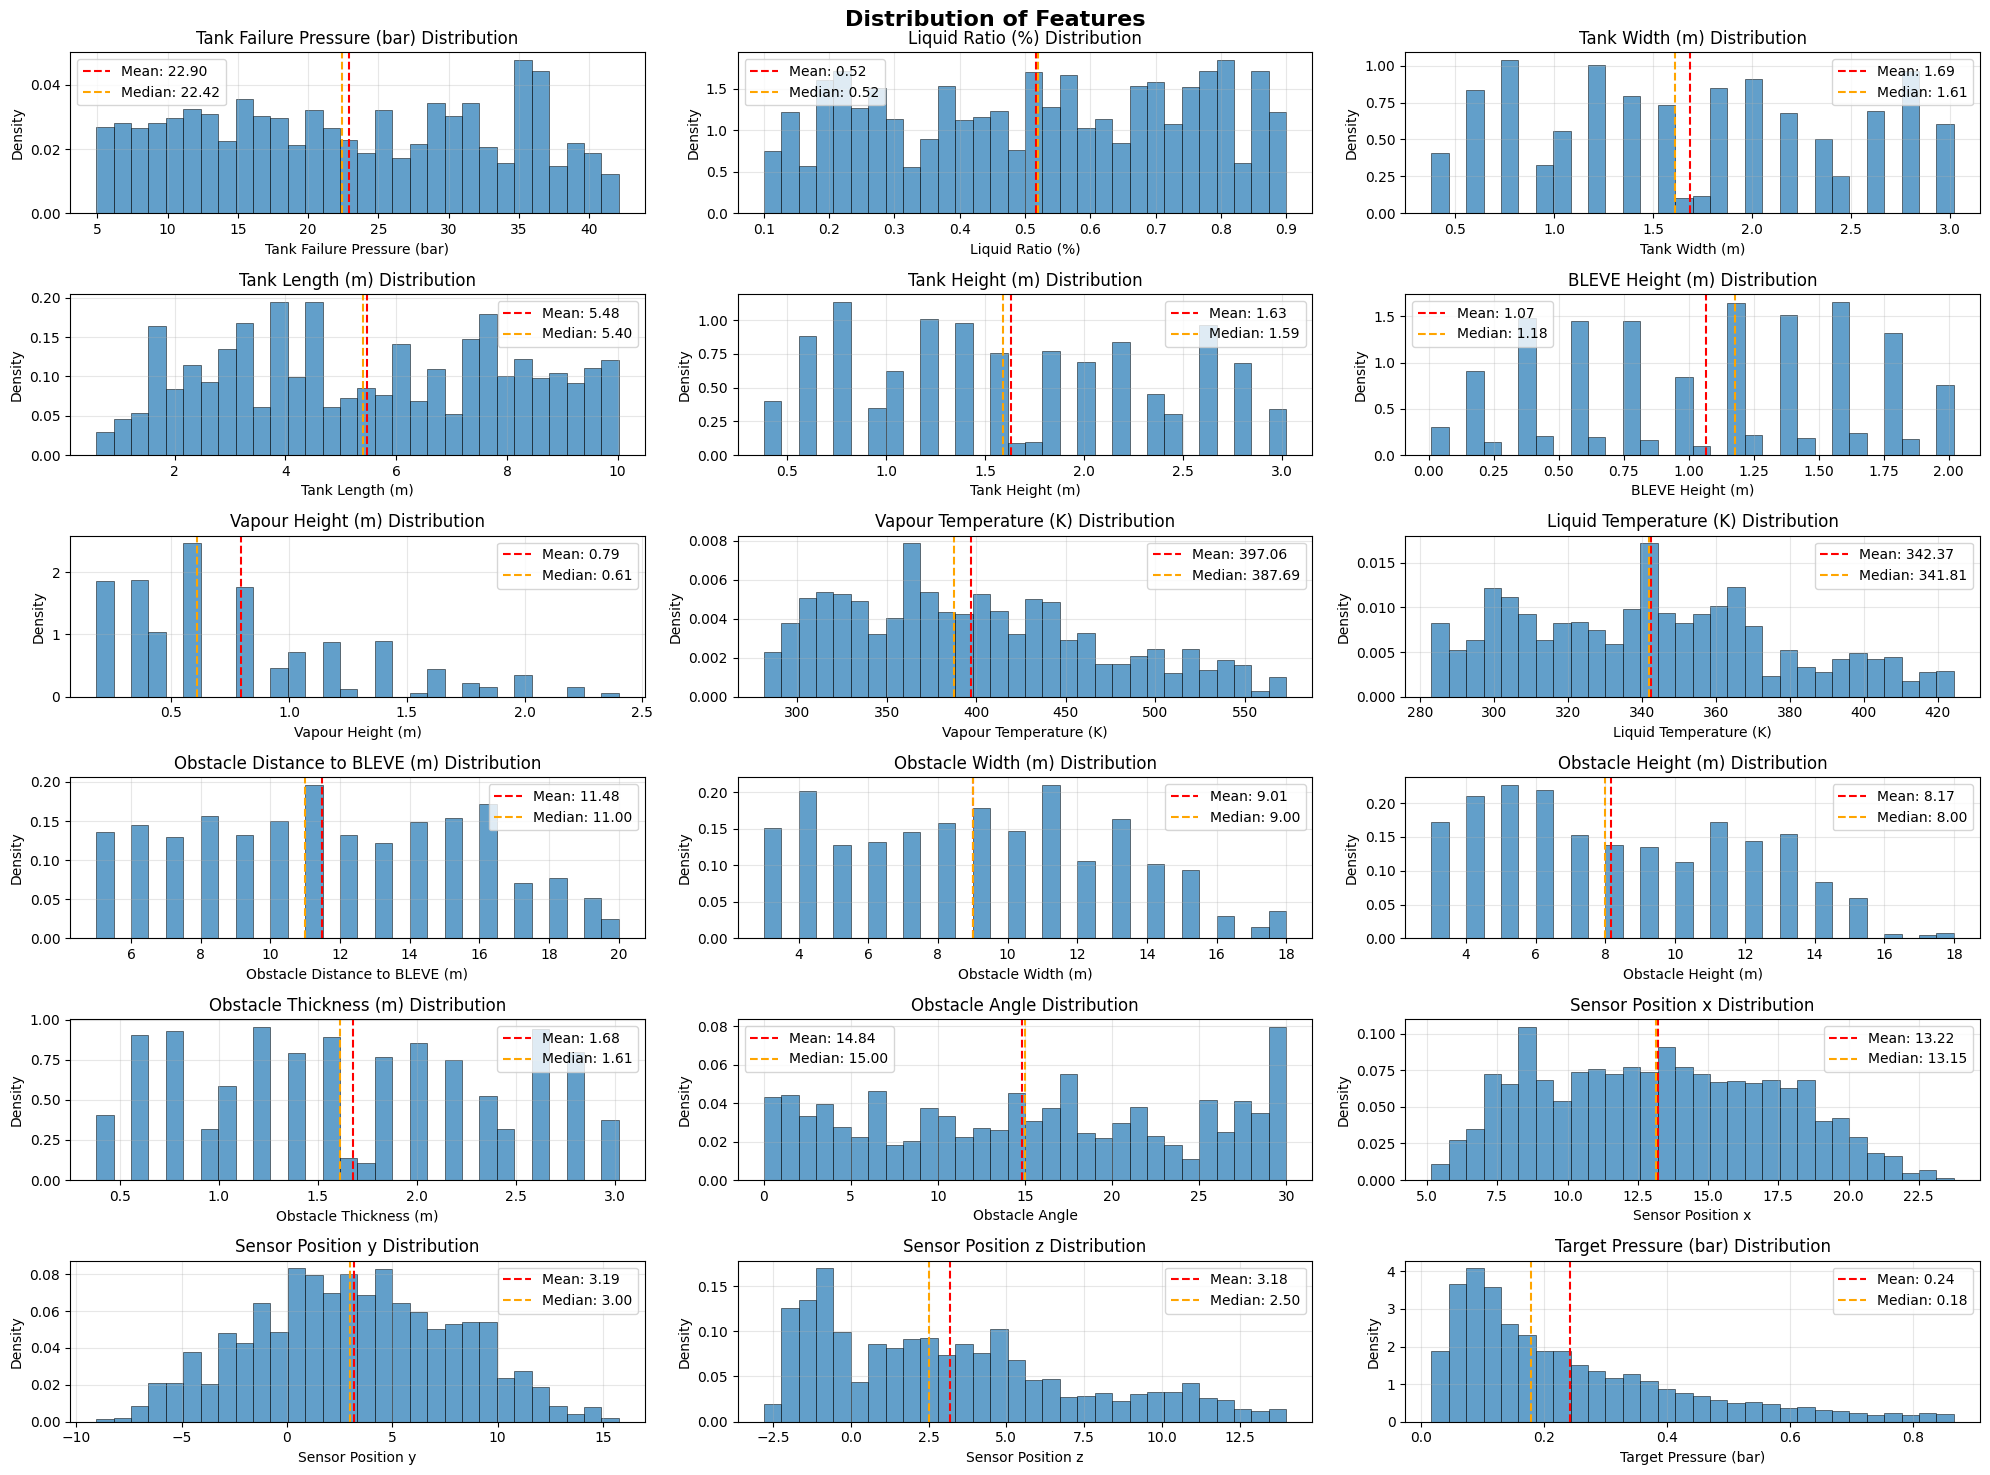

In [ ]:
excluded_cols = [
    'Liquid Critical Pressure (bar)',
    'Liquid Boiling Temperature (K)',
    'Liquid Critical Temperature (K)',
    'Sensor Position Side'
]

filtered_num_col_lst = [col for col in num_col_lst if col not in excluded_cols]


N = len(filtered_num_col_lst)
R = math.ceil(N / 3)

fig, axes = plt.subplots(R, 3, figsize=(20, 15))
fig.suptitle('Distribution of Features', fontsize=16, fontweight='bold')

axes = axes.flatten()

for i in range(N):
    feat = filtered_num_col_lst[i]
    ax = axes[i]

    ax.hist(numeric_df[feat], bins=30, alpha=0.7,
                       density=True, edgecolor='black', linewidth=0.5)


    mean_val = numeric_df[feat].mean()
    median_val = numeric_df[feat].median()
    ax.axvline(mean_val, color='red', linestyle='--',
                          label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='orange', linestyle='--',
                          label=f'Median: {median_val:.2f}')

    ax.set_title(f'{feat} Distribution')
    ax.set_xlabel(feat)
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

for j in range(N, R * 3):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### **1.2 Correlation Matrix**

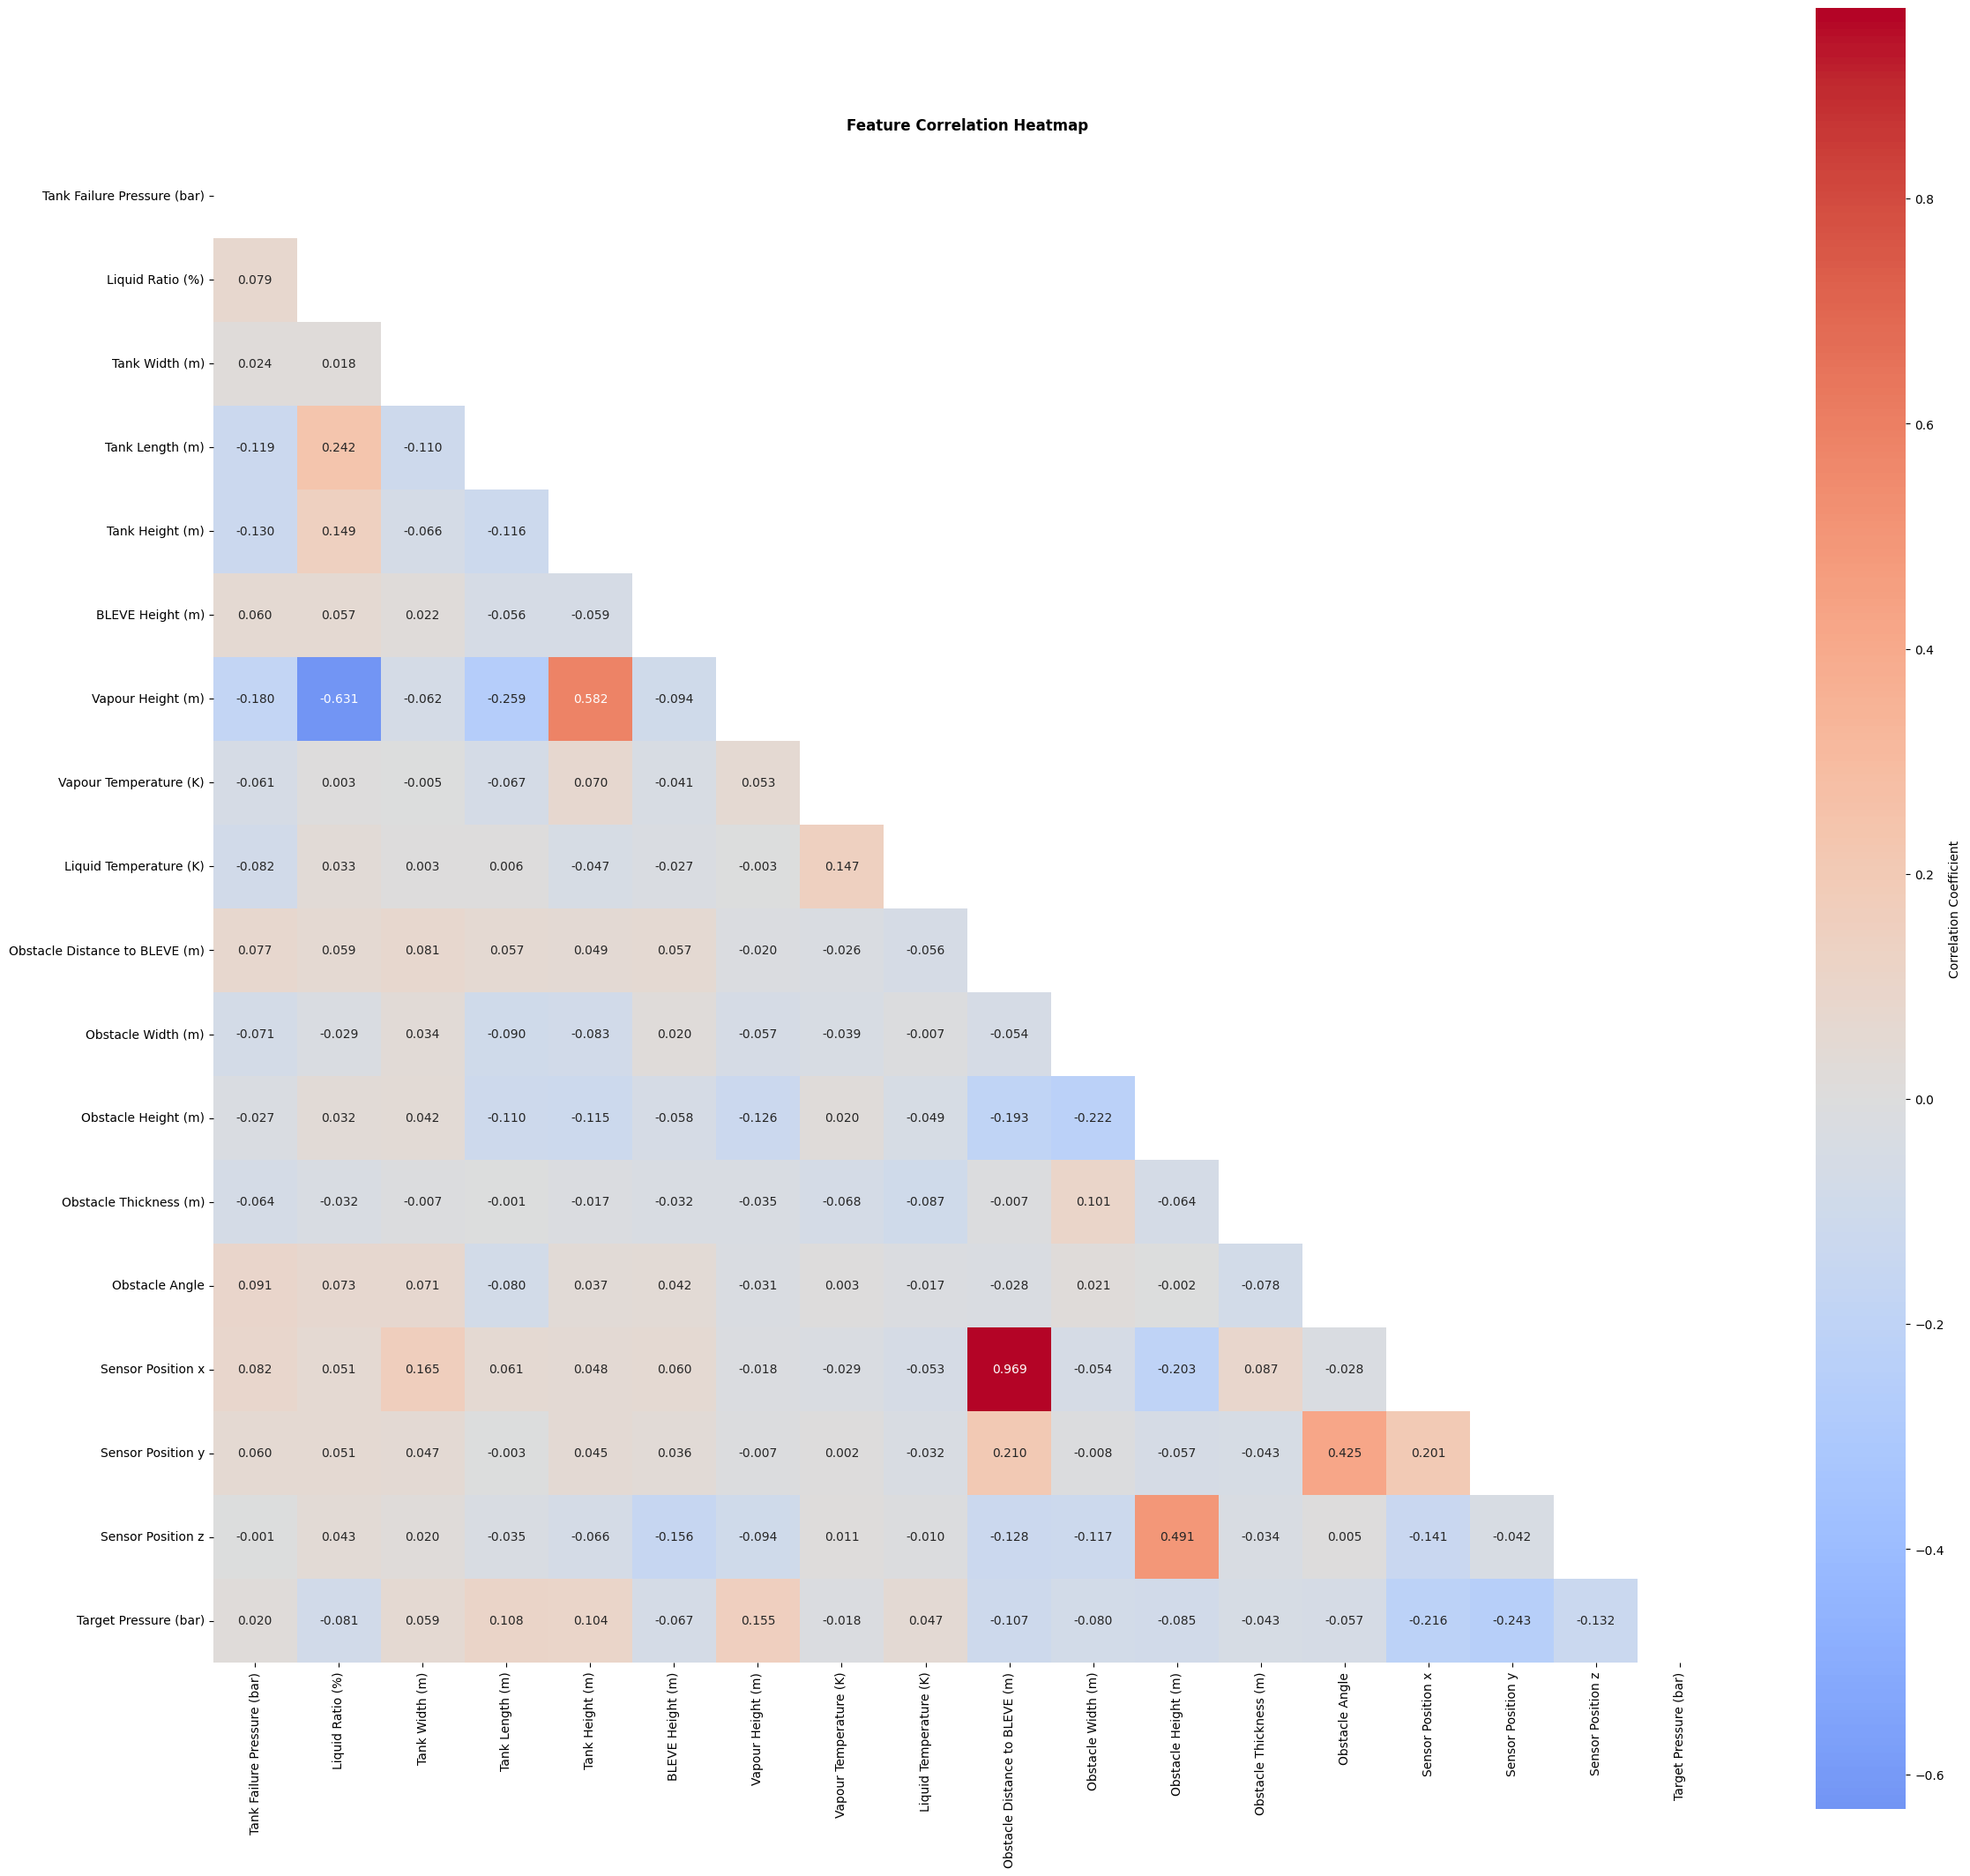

In [ ]:
num_copy = numeric_df.copy()
num_copy.drop(columns=excluded_cols, axis=1, inplace=True, errors='ignore')
num_col_lst_copy = num_copy.columns.tolist()

correlation_matrix = numeric_df[num_col_lst_copy].corr()

plt.figure(figsize=(24, 22))

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix,
            mask=mask,
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            fmt='.3f',
            cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Feature Correlation Heatmap', fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### **1.3 Influence of Categorical Variables**

/tmp/ipython-input-2877090645.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


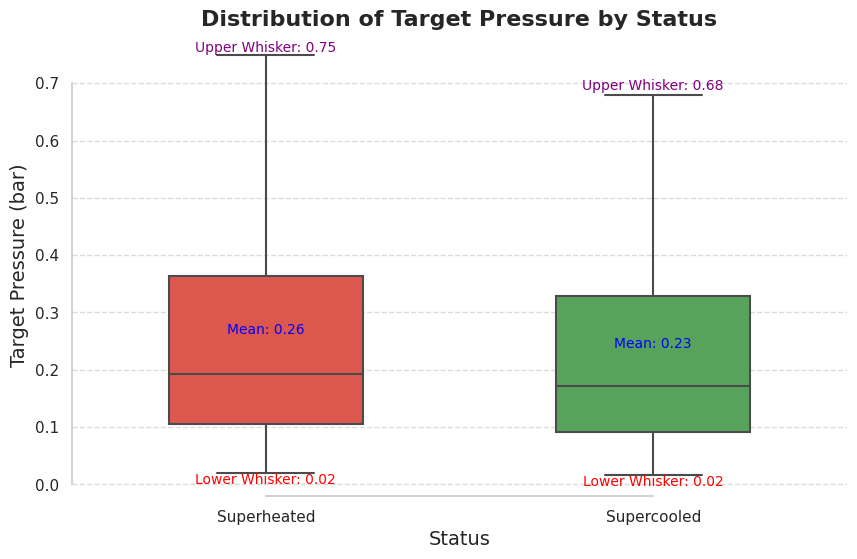

In [ ]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))

ax = sns.boxplot(
    x='Status',
    y='Target Pressure (bar)',
    data=df,
    palette={'Supercooled': '#4CAF50', 'Superheated': '#F44336'},
    width=0.5,
    linewidth=1.5,
    showfliers=False
)

plt.title('Distribution of Target Pressure by Status', fontsize=16, fontweight='bold')
plt.xlabel('Status', fontsize=14)
plt.ylabel('Target Pressure (bar)', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(trim=True)

for i, status in enumerate(df['Status'].unique()):
    subset = df[df['Status'] == status]['Target Pressure (bar)']
    mean_val = subset.mean()
    Q1 = subset.quantile(0.25)
    Q3 = subset.quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR

    lower_whisker = max(lower_whisker, subset.min())
    upper_whisker = min(upper_whisker, subset.max())

    ax.text(i, mean_val, f'Mean: {mean_val:.2f}', ha='center', va='bottom', color='blue', fontsize=10)
    ax.text(i, lower_whisker, f'Lower Whisker: {lower_whisker:.2f}', ha='center', va='top', color='red', fontsize=10)
    ax.text(i, upper_whisker, f'Upper Whisker: {upper_whisker:.2f}', ha='center', va='bottom', color='purple', fontsize=10)

plt.show()


/tmp/ipython-input-975078602.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


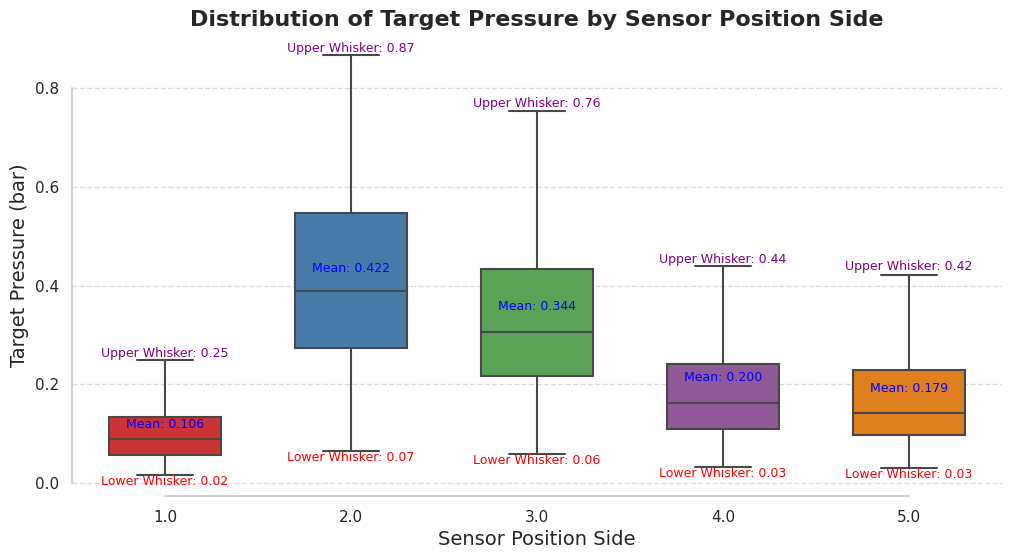

In [ ]:
palette_colors = sns.color_palette("Set1", n_colors=5)

plt.figure(figsize=(12, 6))

ax = sns.boxplot(
    x='Sensor Position Side',
    y='Target Pressure (bar)',
    data=df,
    palette=palette_colors,
    width=0.6,
    linewidth=1.5,
    showfliers=False
)

plt.title('Distribution of Target Pressure by Sensor Position Side', fontsize=16, fontweight='bold')
plt.xlabel('Sensor Position Side', fontsize=14)
plt.ylabel('Target Pressure (bar)', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(trim=True)

sensor_positions = sorted(df['Sensor Position Side'].unique())
for i, position in enumerate(sensor_positions):
    subset = df[df['Sensor Position Side'] == position]['Target Pressure (bar)']

    if not subset.empty:
        mean_val = subset.mean()
        Q1 = subset.quantile(0.25)
        Q3 = subset.quantile(0.75)
        IQR = Q3 - Q1

        lower_whisker_calc = Q1 - 1.5 * IQR
        upper_whisker_calc = Q3 + 1.5 * IQR

        lower_whisker = max(lower_whisker_calc, subset.min())
        upper_whisker = min(upper_whisker_calc, subset.max())

        ax.text(i, mean_val, f'Mean: {mean_val:.3f}', ha='center', va='bottom', color='blue', fontsize=9)
        ax.text(i, lower_whisker, f'Lower Whisker: {lower_whisker:.2f}', ha='center', va='top', color='red', fontsize=9)
        ax.text(i, upper_whisker, f'Upper Whisker: {upper_whisker:.2f}', ha='center', va='bottom', color='purple', fontsize=9)

plt.show()

/tmp/ipython-input-3310451469.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


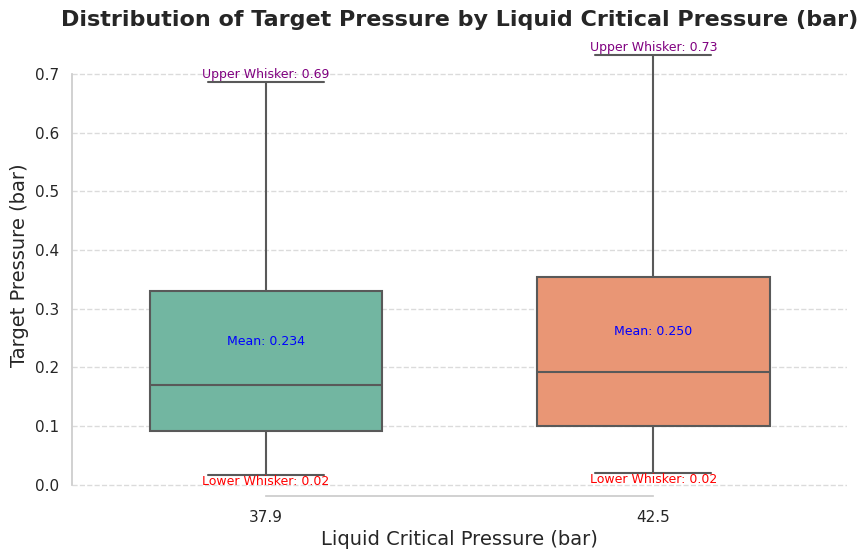

In [ ]:
palette_colors = sns.color_palette("Set2", n_colors=2)

plt.figure(figsize=(10, 6))

ax = sns.boxplot(
    x='Liquid Critical Pressure (bar)',
    y='Target Pressure (bar)',
    data=df,
    palette=palette_colors,
    width=0.6,
    linewidth=1.5,
    showfliers=False
)

plt.title('Distribution of Target Pressure by Liquid Critical Pressure (bar)', fontsize=16, fontweight='bold')
plt.xlabel('Liquid Critical Pressure (bar)', fontsize=14)
plt.ylabel('Target Pressure (bar)', fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(trim=True)

sensor_positions = sorted(df['Liquid Critical Pressure (bar)'].unique())
for i, position in enumerate(sensor_positions):
    subset = df[df['Liquid Critical Pressure (bar)'] == position]['Target Pressure (bar)']

    if not subset.empty:
        mean_val = subset.mean()
        Q1 = subset.quantile(0.25)
        Q3 = subset.quantile(0.75)
        IQR = Q3 - Q1

        lower_whisker_calc = Q1 - 1.5 * IQR
        upper_whisker_calc = Q3 + 1.5 * IQR

        lower_whisker = max(lower_whisker_calc, subset.min())
        upper_whisker = min(upper_whisker_calc, subset.max())

        ax.text(i, mean_val, f'Mean: {mean_val:.3f}', ha='center', va='bottom', color='blue', fontsize=9)
        ax.text(i, lower_whisker, f'Lower Whisker: {lower_whisker:.2f}', ha='center', va='top', color='red', fontsize=9)
        ax.text(i, upper_whisker, f'Upper Whisker: {upper_whisker:.2f}', ha='center', va='bottom', color='purple', fontsize=9)

plt.show()

In [ ]:
df_copy = df.copy()

df_copy['Sensor Position Side'] = df_copy['Sensor Position Side'].astype(str)
df_copy['Liquid Critical Pressure (bar)'] = df_copy['Liquid Critical Pressure (bar)'].astype(str)


**Interpretation of ANOVA results:**

*   **Sum Sq:** The sum of squares for each source of variation.
*   **df:** The degrees of freedom for each source of variation.
*   **F:** The F-statistic, which is the ratio of the variance between the groups to the variance within the groups. A larger F-statistic suggests a greater difference between group means.
*   **PR(>F):** The p-value. This is the probability of observing the F-statistic (or a more extreme value) if there were no real difference between the group means (i.e., under the null hypothesis). A small p-value (commonly < 0.05) indicates that the difference in means between the groups is statistically significant.

Based on the p-value, you can determine if there is a significant difference in 'Target Pressure (bar)' between the 'Supercooled' and 'Superheated' statuses.

In [ ]:
categorical_col = ['Status','Sensor Position Side', 'Liquid Critical Pressure (bar)']

for col in categorical_col:

    formula = f'Q("Target Pressure (bar)") ~ C(Q("{col}"))'
    model = ols(formula, data=df_copy).fit()
    result_anova = sm.stats.anova_lm(model)
    print(f"\nANOVA results for '{col}':")
    print(result_anova)


ANOVA results for 'Status':
                    df      sum_sq   mean_sq          F        PR(>F)
C(Q("Status"))     1.0    1.293074  1.293074  36.223233  1.832060e-09
Residual        8549.0  305.176744  0.035697        NaN           NaN

ANOVA results for 'Sensor Position Side':
                                  df      sum_sq    mean_sq            F  \
C(Q("Sensor Position Side"))     4.0  150.442749  37.610687  2060.033153   
Residual                      8546.0  156.027069   0.018257          NaN   

                              PR(>F)  
C(Q("Sensor Position Side"))     0.0  
Residual                         NaN  

ANOVA results for 'Liquid Critical Pressure (bar)':
                                            df      sum_sq   mean_sq  \
C(Q("Liquid Critical Pressure (bar)"))     1.0    0.544795  0.544795   
Residual                                8549.0  305.925024  0.035785   

                                               F    PR(>F)  
C(Q("Liquid Critical Pressure (bar)"))  1

# **2. Cleaning the Data**

(Although we've cleaned it already prior to EDA, we will confirm once again before train-test split)

In [ ]:
df

,Tank Failure Pressure (bar),Liquid Ratio (%),Tank Width (m),Tank Length (m),Tank Height (m),BLEVE Height (m),Vapour Height (m),Vapour Temperature (K),Liquid Temperature (K),Obstacle Distance to BLEVE (m),...,Obstacle Angle,Status,Liquid Critical Pressure (bar),Liquid Boiling Temperature (K),Liquid Critical Temperature (K),Sensor Position Side,Sensor Position x,Sensor Position y,Sensor Position z,Target Pressure (bar)
0,7.32,0.42,2.42,5.39,1.00,1.79,0.60,524.61,354.49,11.0,...,13.0,Superheated,37.9,-1.0,152.0,2.0,12.15,7.90,10.7,0.199929
1,7.18,0.42,2.39,5.39,1.01,1.81,0.59,522.80,354.31,11.0,...,13.0,Superheated,37.9,-1.0,152.0,3.0,12.50,-2.95,-1.9,0.435681
2,7.32,0.41,2.39,5.38,1.00,1.78,0.62,523.00,354.59,11.0,...,13.0,Superheated,37.9,-1.0,152.0,3.0,12.50,-2.95,4.4,0.264031
3,7.26,0.42,2.40,5.41,1.00,1.81,0.61,522.35,354.37,11.0,...,13.0,Superheated,37.9,-1.0,152.0,3.0,12.50,-2.95,10.7,0.270576
4,7.32,0.42,2.40,5.41,1.02,1.79,0.62,522.98,354.33,11.0,...,13.0,Superheated,37.9,-1.0,152.0,4.0,12.50,-2.70,11.0,0.204675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,18.45,0.56,2.00,7.18,0.99,0.21,0.38,540.56,319.47,14.0,...,3.0,Supercooled,37.9,-1.0,152.0,2.0,14.95,6.60,7.1,0.330830
9991,18.18,0.57,1.98,7.19,0.98,0.20,0.40,539.85,318.72,14.0,...,3.0,Supercooled,37.9,-1.0,152.0,3.0,16.10,-5.25,-0.2,0.250365
9992,18.12,0.57,1.99,7.22,1.00,0.19,0.41,538.81,318.39,14.0,...,3.0,Supercooled,37.9,-1.0,152.0,3.0,16.10,-5.25,7.1,0.250067
9997,18.21,0.57,1.98,7.19,1.00,0.19,0.39,540.22,319.25,14.0,...,3.0,Supercooled,37.9,-1.0,152.0,5.0,16.10,6.85,-0.2,0.112795


In [ ]:
nan_rows = df[df.isnull().any(axis=1)]
num_nan_rows = len(nan_rows)
print(f"Number of rows with NaN values: {num_nan_rows}")

Number of rows with NaN values: 0


In [ ]:
num_duplicate_rows = df.duplicated().sum()
print(f"Number of repeated rows: {num_duplicate_rows}")

Number of repeated rows: 0


# **3. Encoding + Test-Train Split**

- Encoding our 4 categorical variables here.

In [ ]:

categorical_cols = [
    'Liquid Critical Pressure (bar)',
    'Liquid Boiling Temperature (K)',
    'Liquid Critical Temperature (K)',
    'Sensor Position Side',
    'Status'
]

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols),index=df.index)

df_final = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

- Using stratified splitting here. By looking at the distribution of the target variable from our EDA, creating 3 bins: (0, 0.3], (0.3, 0.6] and [0.6, max(target)). This division is done by simple visual observation.

In [ ]:
X = df_final.drop('Target Pressure (bar)', axis=1)
y = df_final['Target Pressure (bar)']

bins = [0,0.3,0.6,y.max()]
labels = ['Low', 'Medium', 'High']


y_binned = pd.cut(y, bins=bins, labels=labels, include_lowest=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y_binned
)

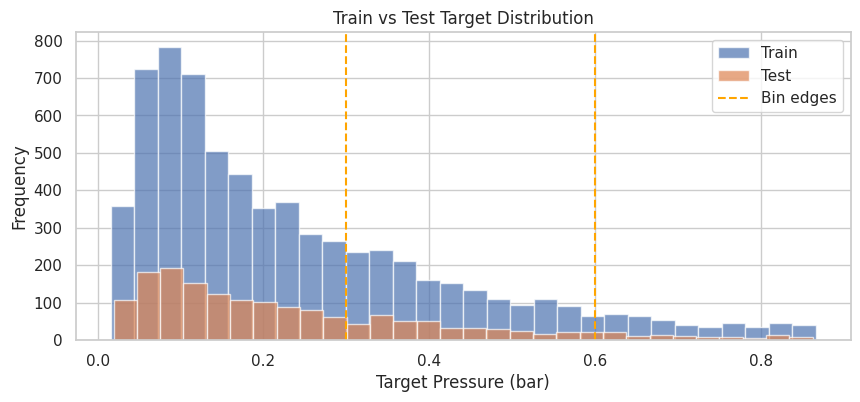

In [ ]:
plt.figure(figsize=(10,4))
plt.hist(y_train, bins=30, alpha=0.7, label='Train')
plt.hist(y_test, bins=30, alpha=0.7, label='Test')
plt.axvline(0.3, color='orange', linestyle='--', label='Bin edges')
plt.axvline(0.6, color='orange', linestyle='--')
plt.title('Train vs Test Target Distribution')
plt.xlabel('Target Pressure (bar)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

- Now, standardizing our test and train data (excluding the encoded features as they are not supposed to be sandardized)

In [ ]:
all_cols = X_train.columns.tolist()
numerical_cols = [col for col in all_cols if col not in X_train.columns[X_train.columns.str.contains('_')].tolist()]
ohe_cols = [col for col in all_cols if col not in numerical_cols]

scaler = StandardScaler()
scaler.fit(X_train[numerical_cols])


# Transforming, and recombining with the encoded columns, the train data

X_train_scaled_num = pd.DataFrame(
    scaler.transform(X_train[numerical_cols]),
    columns=numerical_cols,
    index=X_train.index
)


X_train_final = pd.concat([X_train_scaled_num, X_train[ohe_cols]], axis=1)


# Transforming, and recombining with the encoded columns, the test data

X_test_scaled_num = pd.DataFrame(
    scaler.transform(X_test[numerical_cols]),
    columns=numerical_cols,
    index=X_test.index
)

X_test_final = pd.concat([X_test_scaled_num, X_test[ohe_cols]], axis=1)



# **4. Developing Baseline Models**

### **Baseline Model 1 - Linear Regression**
- Starting off with a linear regression model for interpretability

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_final, y_train)

y_train_pred = lin_reg.predict(X_train_final)
y_test_pred = lin_reg.predict(X_test_final)

train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = train_mse ** 0.5
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = test_mse ** 0.5
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {train_rmse:.4f}, R2: {train_r2:.4f}")
print(f"Test RMSE: {test_rmse:.4f}, R2: {test_r2:.4f}")


Train RMSE: 0.1002, R2: 0.7201
Test RMSE: 0.0986, R2: 0.7269


In [ ]:
print(f"Train MSE: {train_mse:.4f}, Train RMSE: {train_rmse:.4f}, R2: {train_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}, Test RMSE: {test_rmse:.4f}, R2: {test_r2:.4f}")

Train MSE: 0.0100, Train RMSE: 0.1002, R2: 0.7201
Test MSE: 0.0097, Test RMSE: 0.0986, R2: 0.7269


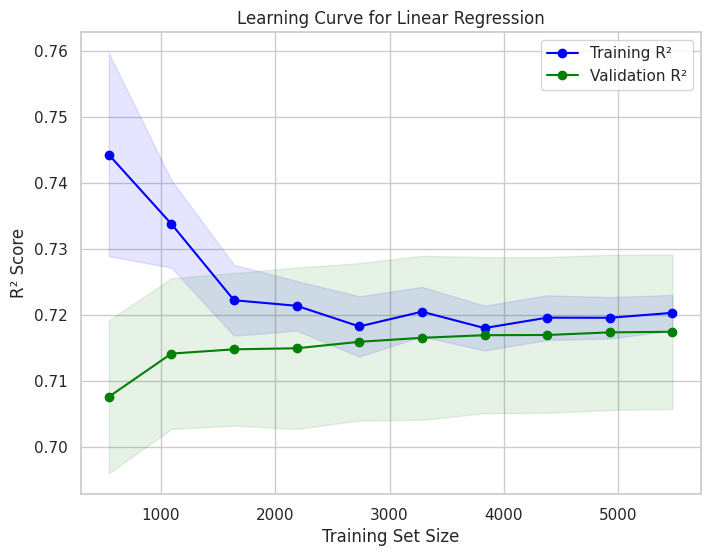

In [ ]:
r2_scorer = make_scorer(r2_score)

train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, test_scores = learning_curve(
    lin_reg,
    X_train_final,
    y_train,
    cv=5,
    scoring=r2_scorer,
    train_sizes=train_sizes,
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training R²')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Validation R²')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
plt.title('Learning Curve for Linear Regression')
plt.xlabel('Training Set Size')
plt.ylabel('R² Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

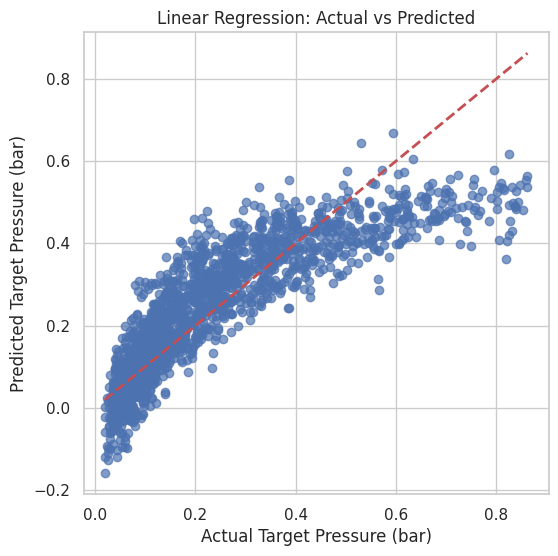

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Target Pressure (bar)")
plt.ylabel("Predicted Target Pressure (bar)")
plt.title("Linear Regression: Actual vs Predicted")
plt.show()


Now, using SHAP, determining the feature importance for this model.


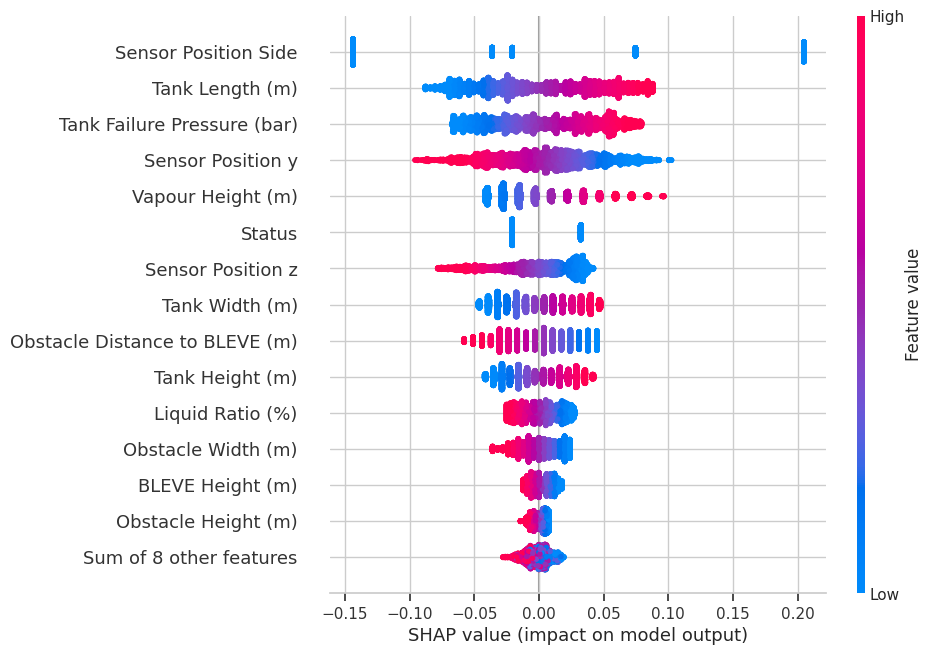

In [ ]:
# Step 1: Create a mapping from encoded column to original feature
lin_group_feature_map = {
    col: col.split('_')[0] if '_' in col else col
    for col in X_train_final.columns
}

# Step 2: Compute SHAP values for Linear Regression
lin_group_explainer = shap.Explainer(lin_reg, X_train_final)
lin_group_shap_values = lin_group_explainer(X_train_final)

# Step 3: Group SHAP values and input data using .T workaround
lin_group_shap_df = pd.DataFrame(lin_group_shap_values.values, columns=X_train_final.columns)
lin_group_shap_grouped = lin_group_shap_df.T.groupby(lin_group_feature_map).sum().T
lin_group_X_grouped = X_train_final.T.groupby(lin_group_feature_map).sum().T

# Step 4: Create grouped SHAP Explanation object
lin_grouped_explanation = shap.Explanation(
    values=lin_group_shap_grouped.values,
    data=lin_group_X_grouped.values,
    feature_names=list(lin_group_X_grouped.columns)
)

# Step 5: Plot grouped SHAP beeswarm
plt.figure(figsize=(12, 6))
shap.plots.beeswarm(lin_grouped_explanation, max_display=15)

### **Baseline Model 2 - Random Forest**
- This model will help us capture some of the non-linearities. We will first find the optimal hyperparameters for the best possible generalization.

In [ ]:
param_dist = {
    "n_estimators": [600],
    "max_depth": [8, 10, 12],
    "min_samples_split": [40, 45, 50],
    "min_samples_leaf": [15, 20, 25],
    "max_features": ["sqrt", 0.6, 0.7, 0.8],
    "bootstrap": [True]
}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,          # number of random combinations to try
    scoring='r2',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_final, y_train)

print("Best hyperparameters found:")
print(random_search.best_params_)

best_rf = random_search.best_estimator_

y_train_pred_rf_best_param = best_rf.predict(X_train_final)
y_test_pred_rf_best_param = best_rf.predict(X_test_final)

def evaluate(y_true, y_pred, dataset_name="Dataset"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{dataset_name} Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}\n")

evaluate(y_train, y_train_pred_rf_best_param, "Train")
evaluate(y_test, y_test_pred_rf_best_param, "Test")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters found:
{'n_estimators': 600, 'min_samples_split': 40, 'min_samples_leaf': 15, 'max_features': 0.6, 'max_depth': 10, 'bootstrap': True}
Train Metrics:
  RMSE: 0.0718
  MAE: 0.0477
  R²: 0.8566

Test Metrics:
  RMSE: 0.0815
  MAE: 0.0557
  R²: 0.8134



- To further minimize the slight overfitting done by the best hyperparameters found above, we are slightly altering the parameters for a more general output. These values were not used during tuning because the computation time was quite excessive owing to the iterations being performed by the RandomSearchCV. Through the RandomSearchCV, we found an approximate range of parameters and their effect on the bias/variance trade-off

In [ ]:
best_params_rf = {
    'n_estimators': 600,
    'min_samples_split': 50,
    'min_samples_leaf': 25,
    'max_features': 0.5,
    'max_depth': 8,
    'bootstrap': True,
    'random_state': 42
}

best_rf_optimized = RandomForestRegressor(**best_params_rf)

print("Training the final RandomForestRegressor...")
best_rf_optimized.fit(X_train_final, y_train)

y_train_pred_rf_best_param_opt = best_rf_optimized.predict(X_train_final)
y_test_pred_rf_best_param_opt = best_rf_optimized.predict(X_test_final)

evaluate(y_train, y_train_pred_rf_best_param_opt, "Train")
evaluate(y_test, y_test_pred_rf_best_param_opt, "Test")

Training the final RandomForestRegressor...
Train Metrics:
  RMSE: 0.0822
  MAE: 0.0557
  R²: 0.8120

Test Metrics:
  RMSE: 0.0884
  MAE: 0.0616
  R²: 0.7803



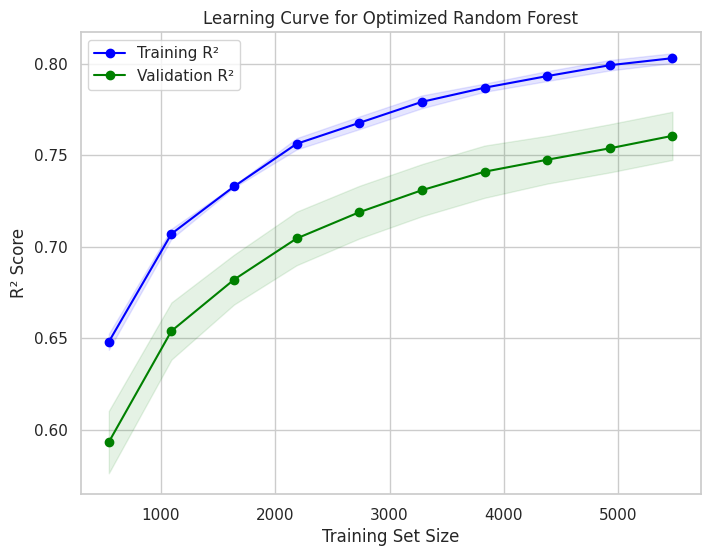

In [ ]:
train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, test_scores = learning_curve(
    best_rf_optimized,
    X_train_final,
    y_train,
    cv=5,
    scoring='r2',
    train_sizes=train_sizes,
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training R²')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Validation R²')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
plt.title('Learning Curve for Optimized Random Forest')
plt.xlabel('Training Set Size')
plt.ylabel('R² Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

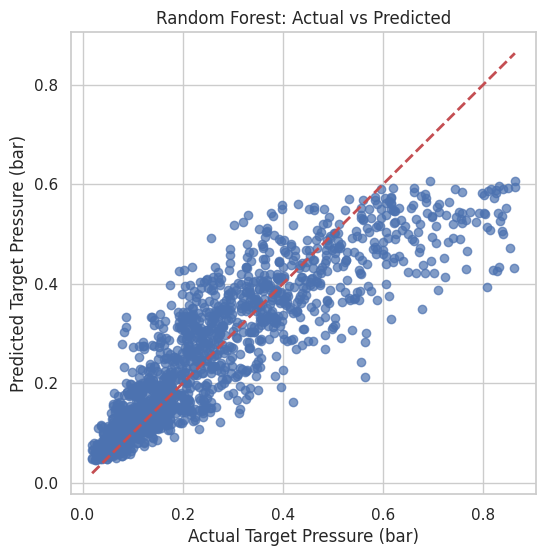

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred_rf_best_param_opt, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Target Pressure (bar)")
plt.ylabel("Predicted Target Pressure (bar)")
plt.title("Random Forest: Actual vs Predicted")
plt.show()


- Now, for grouped categorical variables

100%|===================| 6837/6840 [11:50<00:00]       

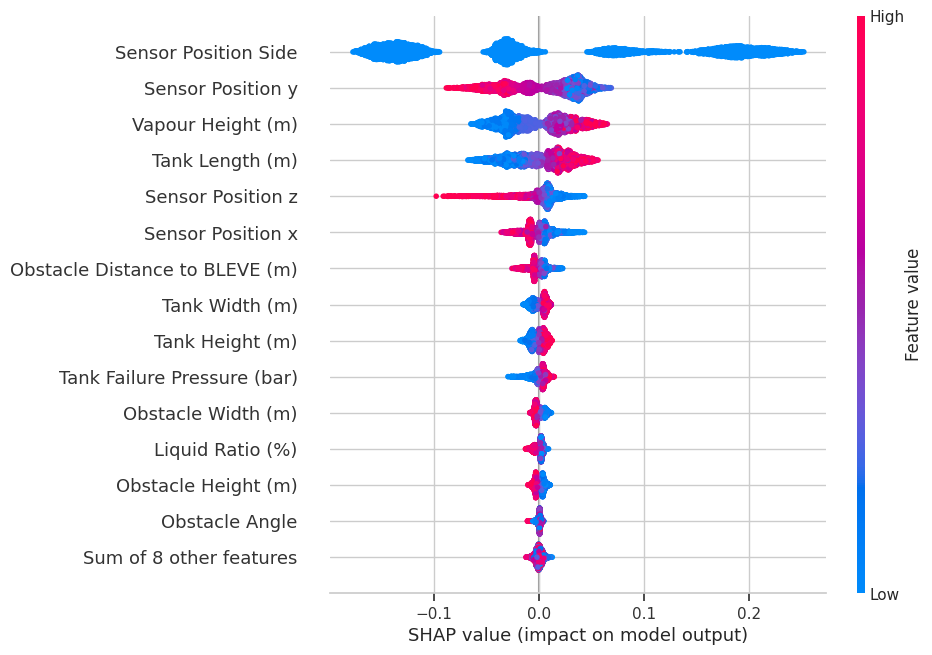

In [ ]:

rf_group_feature_map = {
    col: col.split('_')[0] if '_' in col else col
    for col in X_train_final.columns
}


rf_group_explainer = shap.Explainer(best_rf_optimized, X_train_final)
rf_group_shap_values = rf_group_explainer(X_train_final)

# Step 3: Group SHAP values and input data using .T workaround
rf_group_shap_df = pd.DataFrame(rf_group_shap_values.values, columns=X_train_final.columns)
rf_group_shap_grouped = rf_group_shap_df.T.groupby(rf_group_feature_map).sum().T
rf_group_X_grouped = X_train_final.T.groupby(rf_group_feature_map).sum().T

# Step 4: Create grouped SHAP Explanation object
rf_grouped_explanation = shap.Explanation(
    values=rf_group_shap_grouped.values,
    data=rf_group_X_grouped.values,
    feature_names=list(rf_group_X_grouped.columns)
)

# Step 5: Plot grouped SHAP beeswarm
plt.figure(figsize=(12, 6))
shap.plots.beeswarm(rf_grouped_explanation, max_display=15)

### **Actual Model - XGBoost**

- Next, we move on to the XGBoost model. Similar to the Random Forest, we will fist tune and find a rough range of hyperparameters, and then run our XGBoost with optimized hyperparameters.

In [ ]:


xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_dist_xgb = {
    "n_estimators": [400, 500, 600, 700, 800],
    "max_depth": [6, 7, 8, 10],
    "learning_rate": [0.02, 0.03, 0.04, 0.05],
    "subsample": [0.6, 0.7, 0.8, 0.85, 0.9],
    "colsample_bytree": [0.6, 0.65, 0.7],
    "gamma": [0.01, 0.2, 0.3],
    "reg_alpha": [0.25, 0.3, 0.5],
    "reg_lambda": [1, 1.5, 2, 2.5, 3]
}

random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=20,
    scoring='r2',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search_xgb.fit(X_train_final, y_train)

print("Best hyperparameters for XGBoost:")
print(random_search_xgb.best_params_)

best_xgb = random_search_xgb.best_estimator_

y_train_pred_xgb = best_xgb.predict(X_train_final)
y_test_pred_xgb = best_xgb.predict(X_test_final)

evaluate(y_train, y_train_pred_xgb, "Train (XGBoost)")
evaluate(y_test, y_test_pred_xgb, "Test (XGBoost)")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters for XGBoost:
{'subsample': 0.6, 'reg_lambda': 2.5, 'reg_alpha': 0.5, 'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.01, 'colsample_bytree': 0.7}
Train (XGBoost) Metrics:
  RMSE: 0.0391
  MAE: 0.0270
  R²: 0.9573

Test (XGBoost) Metrics:
  RMSE: 0.0542
  MAE: 0.0362
  R²: 0.9175



In [ ]:


xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_dist_xgb_opt = {
    "n_estimators": 600,
    "max_depth": 5,
    "learning_rate": 0.05,
    "subsample": 0.6,
    "colsample_bytree": 0.7,
    "gamma": 0.1,
    "reg_alpha": 2,
    "reg_lambda": 4
}

xgb_model_opt = XGBRegressor(**param_dist_xgb_opt)

# Train the model
print("Training the optimized XGBoost model...")
xgb_model_opt.fit(X_train_final, y_train)

# Predictions
y_train_pred_opt = xgb_model_opt.predict(X_train_final)
y_test_pred_opt = xgb_model_opt.predict(X_test_final)

train_mse_opt = mean_squared_error(y_train, y_train_pred_opt)
test_mse_opt = mean_squared_error(y_test, y_test_pred_opt)

train_rmse_opt = sqrt(train_mse_opt)
test_rmse_opt = sqrt(test_mse_opt)

train_mae_opt = mean_absolute_error(y_train, y_train_pred_opt)
test_mae_opt = mean_absolute_error(y_test, y_test_pred_opt)

train_r2_opt = r2_score(y_train, y_train_pred_opt)
test_r2_opt = r2_score(y_test, y_test_pred_opt)


evaluate(y_train, y_train_pred_opt, "Train (XGBoost)")
evaluate(y_test, y_test_pred_opt, "Test (XGBoost)")



Training the optimized XGBoost model...
Train (XGBoost) Metrics:
  RMSE: 0.0650
  MAE: 0.0438
  R²: 0.8822

Test (XGBoost) Metrics:
  RMSE: 0.0706
  MAE: 0.0474
  R²: 0.8601



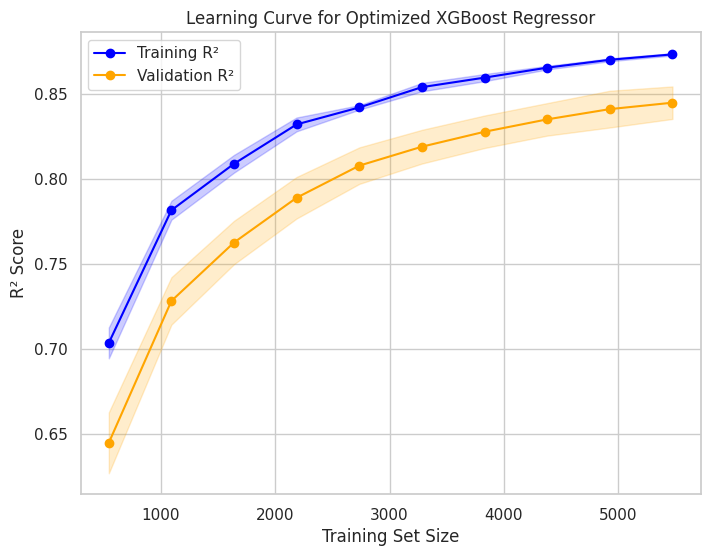

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    xgb_model_opt,
    X_train_final,
    y_train,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

# Compute mean and std for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training R²')
plt.plot(train_sizes, test_mean, 'o-', color='orange', label='Validation R²')

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='orange', alpha=0.2)

plt.title("Learning Curve for Optimized XGBoost Regressor")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()

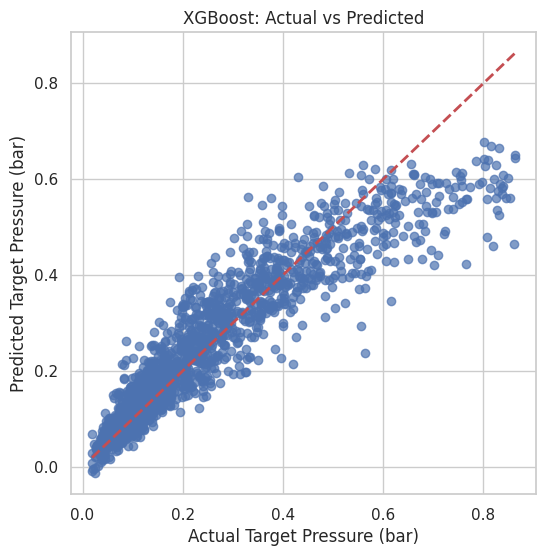

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred_opt, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Target Pressure (bar)")
plt.ylabel("Predicted Target Pressure (bar)")
plt.title("XGBoost: Actual vs Predicted")
plt.show()

- Performing SHAP analysis

/tmp/ipython-input-2580560314.py:13: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  shap_grouped = shap_df.groupby(feature_map, axis=1).sum()
/tmp/ipython-input-2580560314.py:14: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  X_grouped = X_train_final.groupby(feature_map, axis=1).sum()


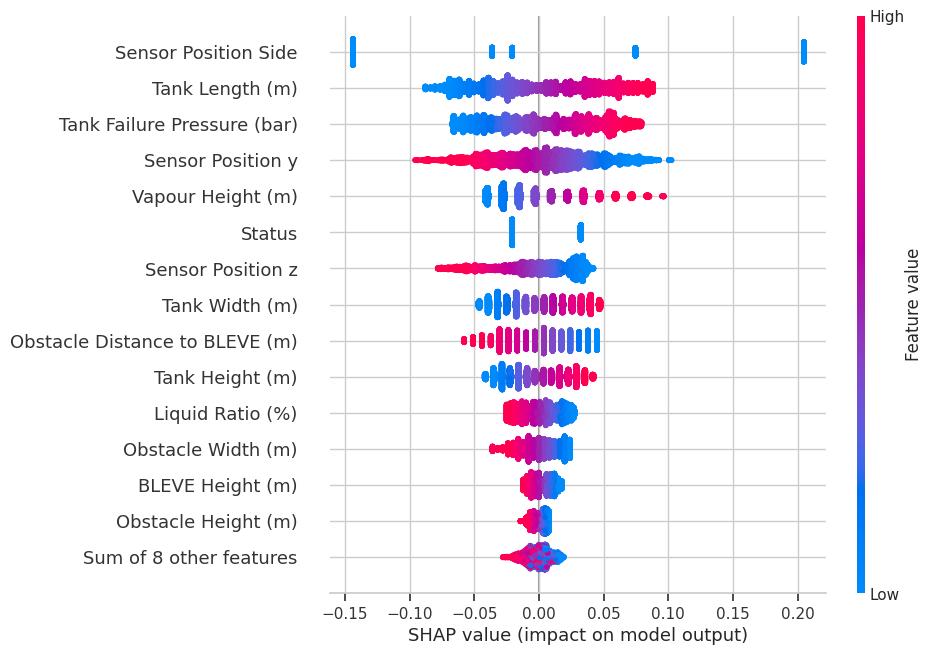

In [ ]:
# Step 1: Create a mapping from encoded column to original feature
feature_map = {
    col: col.split('_')[0] if '_' in col else col
    for col in X_train_final.columns
}

# Step 2: Compute SHAP values
explainer = shap.Explainer(lin_reg, X_train_final)
shap_values = explainer(X_train_final)

# Step 3: Convert SHAP values to DataFrame and group by original feature
shap_df = pd.DataFrame(shap_values.values, columns=X_train_final.columns)
shap_grouped = shap_df.groupby(feature_map, axis=1).sum()
X_grouped = X_train_final.groupby(feature_map, axis=1).sum()

# Step 4: Create grouped SHAP Explanation object
grouped_explanation = shap.Explanation(
    values=shap_grouped.values,
    data=X_grouped.values,
    feature_names=list(shap_grouped.columns)
)

# Step 5: Plot grouped SHAP beeswarm
plt.figure(figsize=(12, 6))
shap.plots.beeswarm(grouped_explanation, max_display=15)